In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt, font_manager
# 新增面板數據分析所需的庫
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS, FirstDifferenceOLS
import statsmodels.formula.api as smf

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

In [5]:
from deep_translator import GoogleTranslator
# pip install deep-translator
# 讀取 csv 檔，將財務變數與類別變數分開讀取
df1 = pd.read_csv("fin_x2.csv", index_col=0)
df2 = pd.read_csv("dum_x.csv", index_col=0)

# 將財務變數每一欄位遺漏值以平均數填滿
df1.fillna(df1.mean(), inplace=True)
df2.fillna(value=0, inplace=True)
# 檢查是否還有遺漏值
df1.isnull().sum()
df2.isnull().sum()

# 將 Y 刪除，另存為財務（finance）、類別（category），df_x_fin、df_x_cat 兩變數
df_x_fin = df1.drop(columns = ['Y'])
df_x_cat = df2.drop(columns = ['Y'])
def translate_columns(df, src_lang='zh-TW', dest_lang='en'):
    translator = GoogleTranslator(source=src_lang, target=dest_lang)
    translated_columns = []
    for column in df.columns:
        try:
            translation = translator.translate(column)
            translated_columns.append(translation)
        except Exception as e:
            print(f"Error translating column '{column}': {e}")
            translated_columns.append(column)  # Fallback to original column name
    df.columns = translated_columns
    return df, translated_columns

# # 將財務變數與類別變數的列名翻譯成英文
# df_x_fin = translate_columns(df_x_fin)
# df_x_cat = translate_columns(df_x_cat)

# 將財務變數與類別變數的列名翻譯成英文
df_x_fin, translated_fin_columns = translate_columns(df_x_fin)
df_x_cat, translated_cat_columns = translate_columns(df_x_cat)


In [4]:

# print(df_x_fin.columns)

# 合併財務變數和類別變數
df_x_significant_keep = pd.concat([df_x_fin, df_x_cat], axis=1)

# 儲存翻譯過後的欄位名稱
translated_columns_df = pd.DataFrame({
    'Original Variable': list(df_x_fin.columns) + list(df_x_cat.columns),
    'Translated Variable': translated_fin_columns + translated_cat_columns
})

translated_columns_df.to_csv('translated_columns.csv', index=False)
print("翻譯過後的欄位名稱已儲存至 'translated_columns.csv'")

翻譯過後的欄位名稱已儲存至 'translated_columns.csv'


In [7]:
# 將財務變數標準化
columns_list = df_x_fin.columns.tolist()
for column in columns_list:
    mean_value = df_x_fin[column].mean()
    std_value = df_x_fin[column].std()
    df_x_fin[column] = (df_x_fin[column] - mean_value) / std_value
df_x_fin = np.clip(df_x_fin, -2, 2)

# 結合財務變數與類別變數，設定為自變數 X
X = pd.concat([df_x_fin], axis = 1)
X = pd.concat([df_x_fin, df_x_cat], axis = 1)
y = df1['Y']

# 將數據拆分為訓練集8：驗測集2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16, stratify=y)
# '''
# X_train.to_csv("C:\Users\1\Desktop\python\X_train.csv")
# X_test.to_csv("C:\Users\1\Desktop\python\X_test.csv")
# y_train.to_csv("C:\Users\1\Desktop\python\y_train.csv")
# y_test.to_csv("C:\Users\1\Desktop\python\y_test.csv")
# '''

In [8]:
''' 單因子分析，將所有自變數逐一對 Y 進行羅吉斯迴歸，並取得 P-value '''
pvalue_results = pd.DataFrame(columns=['Variable', 'P-value'])

def format_pvalue(p): 
    if p < 0.001: return '<0.001' 
    elif p < 0.01: return '{:.4f}'.format(p) 
    else: return '{:.4f}'.format(p)

#計算每個變數的p值
for column in X.columns[0:]: 
    model = sm.Logit(y, X[[column]]) 
    result = model.fit() 
    p_value = result.pvalues[column] 
    new_row = pd.DataFrame({ 'Variable': [column], 'P-value': [format_pvalue(p_value)] }) 
    pvalue_results = pd.concat([pvalue_results, new_row], ignore_index=True)

pvalue_results[['Variable', 'P-value']].to_csv("P-value_test.csv", index=False, encoding='utf-8')

#將P-value轉為數值以便排序和比較
pvalue_results['P-value_numeric'] = pd.to_numeric(pvalue_results['P-value'].replace('<0.001', '0.001'))

#依據P值大小排序
pvalue_results = pvalue_results.sort_values('P-value_numeric')

#記錄需要移除的變數 (p值 >= 0.05)
removed_vars = pvalue_results[pvalue_results['P-value_numeric'] >= 0.05] 
kept_vars = pvalue_results[pvalue_results['P-value_numeric'] < 0.05]

#儲存p值結果
pvalue_results[['Variable', 'P-value']].to_csv("P-value_all.csv", index=False, encoding='utf-8') 
kept_vars[['Variable', 'P-value']].to_csv("P-value_significant.csv", index=False, encoding='utf-8')

#保留顯著變數
df_x_significant = X_train.loc[:, kept_vars['Variable']]

#輸出完整的統計信息
print("\n=== 單因子分析結果 ===") 
print(f"原始變數數量: {len(X.columns)}") 
print(f"顯著變數數量: {len(kept_vars)}") 
print(f"移除的變數 (P值 >= 0.05): {list(removed_vars['Variable'])}") 
print(f"保留的變數 (P值 < 0.05): {list(kept_vars['Variable'])}")

#儲存變數篩選結果摘要
selection_summary = pd.DataFrame({ '類別': ['原始變數數', '顯著變數數', '移除變數數'], '數量': [len(X.columns), len(kept_vars), len(removed_vars)] }) 
selection_summary.to_csv("Variable_Selection_Summary.csv", index=False, encoding='utf-8')

Optimization terminated successfully.
         Current function value: 0.684269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692735
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690586
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680165
  

In [18]:
# 計算相關係數矩陣
corr = df_x_significant.corr().round(4)
corr.to_csv("Corr_original.csv")

# 找出高度相關的變數對
high_corr_pairs = []
for i in range(len(corr.columns)):
   for j in range(i+1, len(corr.columns)):
       if abs(corr.iloc[i,j]) > 0.5:
           high_corr_pairs.append((corr.columns[i], corr.columns[j], abs(corr.iloc[i,j])))

# 依相關係數大小排序
high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

# 記錄需要移除的變數
to_remove = set()
for var1, var2, corr_value in high_corr_pairs:
   if var1 not in to_remove and var2 not in to_remove:
       to_remove.add(var2)

# 保留未被移除的變數
columns_to_keep = [col for col in df_x_significant.columns if col not in to_remove]
df_x_significant_keep = df_x_significant[columns_to_keep]

# 儲存結果
corr_remove = df_x_significant_keep.corr().round(4)
df_x_significant_keep.corr().to_csv("Corr_after_removal.csv")

# 輸出完整的統計信息
print("\n=== 相關係數分析結果 ===")
print(f"原始變數數量: {len(df_x_significant.columns)}")
print(f"高相關變數數量: {len(to_remove)}")
print(f"保留變數數量: {len(columns_to_keep)}")
print(f"移除的變數: {list(to_remove)}")
print(f"保留的變數: {columns_to_keep}")

# 儲存變數篩選結果摘要
correlation_summary = pd.DataFrame({
   '類別': ['原始變數數', '高相關變數數', '保留變數數'],
   '數量': [len(df_x_significant.columns), len(to_remove), len(columns_to_keep)]
})
correlation_summary.to_csv("Correlation_Selection_Summary.csv", index=False, encoding='utf-8')

# # 檢查單獨的影響
# model_single = sm.Logit(y_train, sm.add_constant(X_train['高管人數>3人'])).fit()
# print("單獨p值:", model_single.pvalues['高管人數>3人'])



=== 相關係數分析結果 ===
原始變數數量: 52
高相關變數數量: 26
保留變數數量: 26
移除的變數: ['Research development cost rate', 'Net profit margin after tax', 'After-tax net profit growth rate', 'Return on business assets', 'Turnover per share', 'ROA(A) before interest after tax', 'Berry ratio', 'ROE(A) - After tax', 'Business profit growth rate', 'Inventory and accounts receivable/net worth', 'Net profit margin before interest before tax before depreciation', 'ROA(C) before interest before tax depreciation', 'Employment fee rate', 'Operating rate of benefit', 'Operating expense ratio', 'Pre-tax net profit growth rate', 'Continuous interest rate-after tax', 'Average number of days of sale', 'Share capital accounts for the total equity of shareholders', 'Inventory accounts for current assets', 'ROA(B) before interest and depreciation before tax', 'Gross profit margin', 'Net profit margin before tax', 'Net business cycle (date)', 'ROE(B) - Continuous benefits', 'Operating cash flow ratio']
保留的變數: ['Whether internal audit

In [7]:
# 逐步回歸限制版(10個變數 7個財務變數 3個類別變數)
# 讀取財務變數和類別變數
# fin_vars = pd.read_csv('fin_x2.csv').columns.tolist()     # 財務變數列表
# dummy_vars = pd.read_csv('dum_x.csv').columns.tolist()    # 類別變數列表

# 獲取翻譯後的變數列表
fin_vars = df_x_fin.columns.tolist()
dummy_vars = df_x_cat.columns.tolist()


def stepwise_selection(X, y, financial_vars, dummy_vars, initial_list=[], 
                     threshold_in=0.5, threshold_out=0.5, 
                     max_total=12, max_financial=7, max_dummy=2, verbose=True):
   
   included = list(initial_list)
   removed = set()
   
   while True:
       changed = False
       
       # 計算目前各類型變數數量
       current_financial = len([var for var in included if var in financial_vars])
       current_dummy = len([var for var in included if var in dummy_vars])
       
       if len(included) < max_total:
           excluded = list(set(X.columns) - set(included))
           new_pval = pd.Series(index=excluded, dtype=float)
           
           for new_column in excluded:
               # 檢查是否超過限制
               if (new_column in financial_vars and current_financial >= max_financial) or \
                  (new_column in dummy_vars and current_dummy >= max_dummy):
                   continue
                   
               model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit(disp=0)
               new_pval[new_column] = model.pvalues[new_column]
           
           if not new_pval.empty:
               best_pval = new_pval.min()
               if best_pval < threshold_in:
                   best_feature = new_pval.idxmin()
                   included.append(best_feature)
                   changed = True
                   if verbose:
                       print('Add  {:30} with p-value {:.4f}'.format(best_feature, best_pval))
       
       if len(included) > 0:
           model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)
           pvalues = model.pvalues.iloc[1:]
           worst_pval = pvalues.max()
           if worst_pval > threshold_out:
               changed = True
               worst_feature = pvalues.idxmax()
               included.remove(worst_feature)
               removed.add(worst_feature)
               if verbose:
                   print('Drop {:30} with p-value {:.4f}'.format(worst_feature, worst_pval))
       
       if not changed:
           break
   
   # 如果超過限制，分別處理財務和類別變數
   model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)
   pvalues = model.pvalues.iloc[1:]
   
   # 分類當前包含的變數
   current_financial = [var for var in included if var in financial_vars]
   current_dummy = [var for var in included if var in dummy_vars]
   other_vars = [var for var in included if var not in financial_vars and var not in dummy_vars]
   
   # 如果財務變數超過限制
   if len(current_financial) > max_financial:
       financial_pvalues = pvalues[current_financial]
       kept_financial = list(financial_pvalues.sort_values().index[:max_financial])
       removed.update(set(current_financial) - set(kept_financial))
       current_financial = kept_financial
   
   # 如果類別變數超過限制
   if len(current_dummy) > max_dummy:
       dummy_pvalues = pvalues[current_dummy]
       kept_dummy = list(dummy_pvalues.sort_values().index[:max_dummy])
       removed.update(set(current_dummy) - set(kept_dummy))
       current_dummy = kept_dummy
   
   # 更新最終的變數列表
   included = other_vars + current_financial + current_dummy
   
   # 輸出結果
   print("\n=== 逐步迴歸分析結果 ===")
   print(f"原始變數數量: {len(X.columns)}")
   print(f"原始財務變數數量: {len([col for col in X.columns if col in financial_vars])}")
   print(f"原始類別變數數量: {len([col for col in X.columns if col in dummy_vars])}")
   print(f"保留變數數量: {len(included)}")
   print(f"保留財務變數數量: {len([var for var in included if var in financial_vars])}")
   print(f"保留類別變數數量: {len([var for var in included if var in dummy_vars])}")
   print(f"保留其他變數數量: {len([var for var in included if var not in financial_vars and var not in dummy_vars])}")
   print(f"\n移除的變數: {list(removed)}")
   print(f"\n保留的變數: {included}")
   
   return included

# 執行逐步迴歸
X_train = sm.add_constant(df_x_significant_keep)
stepwise_result = stepwise_selection(X_train.iloc[:, 1:], y_train, 
                                  financial_vars=fin_vars,
                                  dummy_vars=dummy_vars,
                                  threshold_in=0.5, 
                                  threshold_out=0.5,
                                  max_total=12,
                                  max_financial=7,
                                  max_dummy=2)

Add  Total liabilities/total net worth with p-value 0.0000
Add  Accounts and notes payable to current liabilities with p-value 0.0001
Add  Regular net profit growth rate with p-value 0.0004
Add  Net worth growth rate          with p-value 0.0016
Add  Whether there has been any change in the financial director within the past 3 years with p-value 0.0010
Add  Cash and cash equivalents to current assets with p-value 0.0023
Add  Outside income and expenses/revenue with p-value 0.0316
Add  Ordinary share capital as a share of total shareholders’ equity with p-value 0.0075
Add  Has there been any change in the chairman of the board within 3 years? with p-value 0.0144

=== 逐步迴歸分析結果 ===
原始變數數量: 26
原始財務變數數量: 20
原始類別變數數量: 6
保留變數數量: 9
保留財務變數數量: 7
保留類別變數數量: 2
保留其他變數數量: 0

移除的變數: []

保留的變數: ['Total liabilities/total net worth', 'Accounts and notes payable to current liabilities', 'Regular net profit growth rate', 'Net worth growth rate', 'Cash and cash equivalents to current assets', 'Outside incom

In [8]:
# ''' 模型選擇 '''
# Model 1 之自變數
result1 = stepwise_result
# 創建新的變數名稱
new_names = [f'x{i+1}' for i in range(len(result1))]
# 創建變數名稱的對照字典
name_mapping = dict(zip(result1, new_names))
# 重命名欄位並建立最終自變數 X 的 DataFrame
X_train_final_1 = X_train[result1].rename(columns=name_mapping)
X_test_final_1 = X_test[result1].rename(columns=name_mapping)
# 印出變數對照表
# print("x_test:", len(y_test))
print("變數對照表:")
for old_name, new_name in name_mapping.items():
   print(f"{new_name}: {old_name}")


變數對照表:
x1: Total liabilities/total net worth
x2: Accounts and notes payable to current liabilities
x3: Regular net profit growth rate
x4: Net worth growth rate
x5: Cash and cash equivalents to current assets
x6: Outside income and expenses/revenue
x7: Ordinary share capital as a share of total shareholders’ equity
x8: Whether there has been any change in the financial director within the past 3 years
x9: Has there been any change in the chairman of the board within 3 years?


In [9]:
# 儲存變數對照表
variable_mapping_df = pd.DataFrame({
   'New Variable': new_names,
   'Original Variable': result1
})
variable_mapping_df.to_excel('variable_mapping.xlsx', index=False)
print("變數對照表已儲存至 'variable_mapping.xlsx'")

變數對照表已儲存至 'variable_mapping.xlsx'


Optimization terminated successfully.
         Current function value: 0.144358
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                  482
Model:                          Logit   Df Residuals:                      472
Method:                           MLE   Df Model:                            9
Date:                Thu, 19 Dec 2024   Pseudo R-squ.:                  0.5121
Time:                        17:17:45   Log-Likelihood:                -69.580
converged:                       True   LL-Null:                       -142.61
Covariance Type:            nonrobust   LLR p-value:                 5.793e-27
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4375      0.528     -8.399      0.000      -5.473      -3.402
x1             4.1415      0.

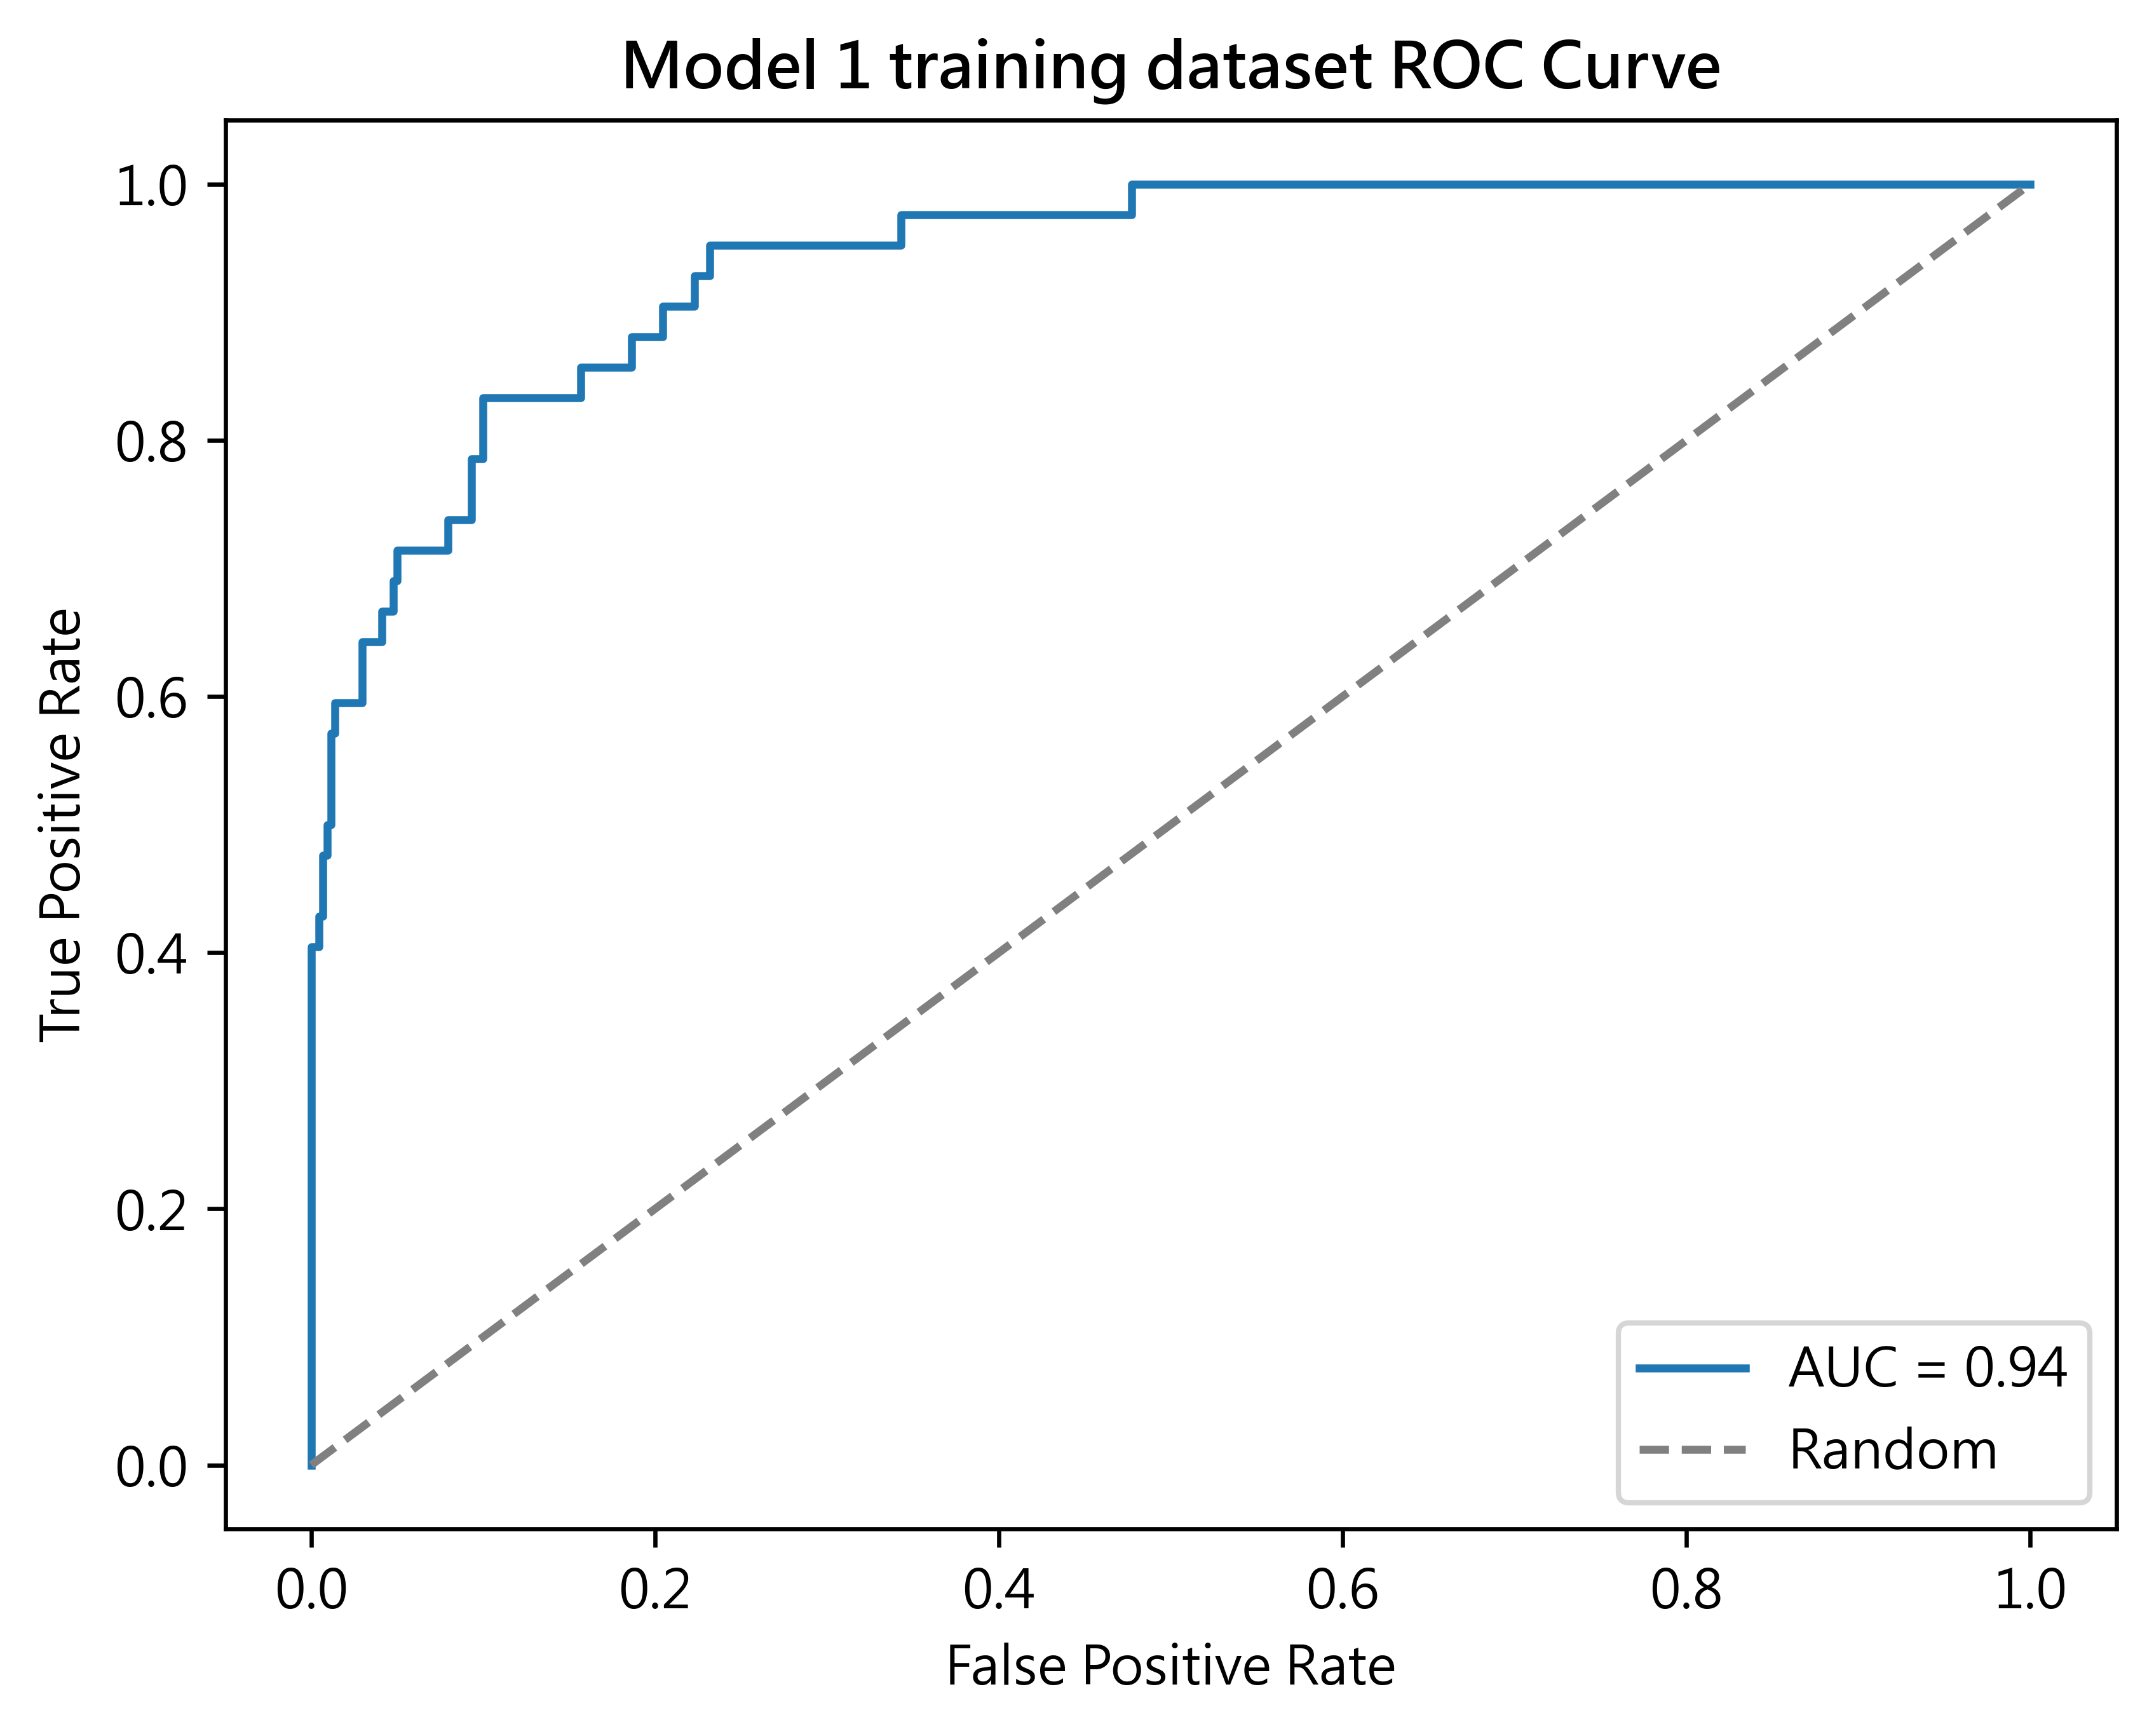

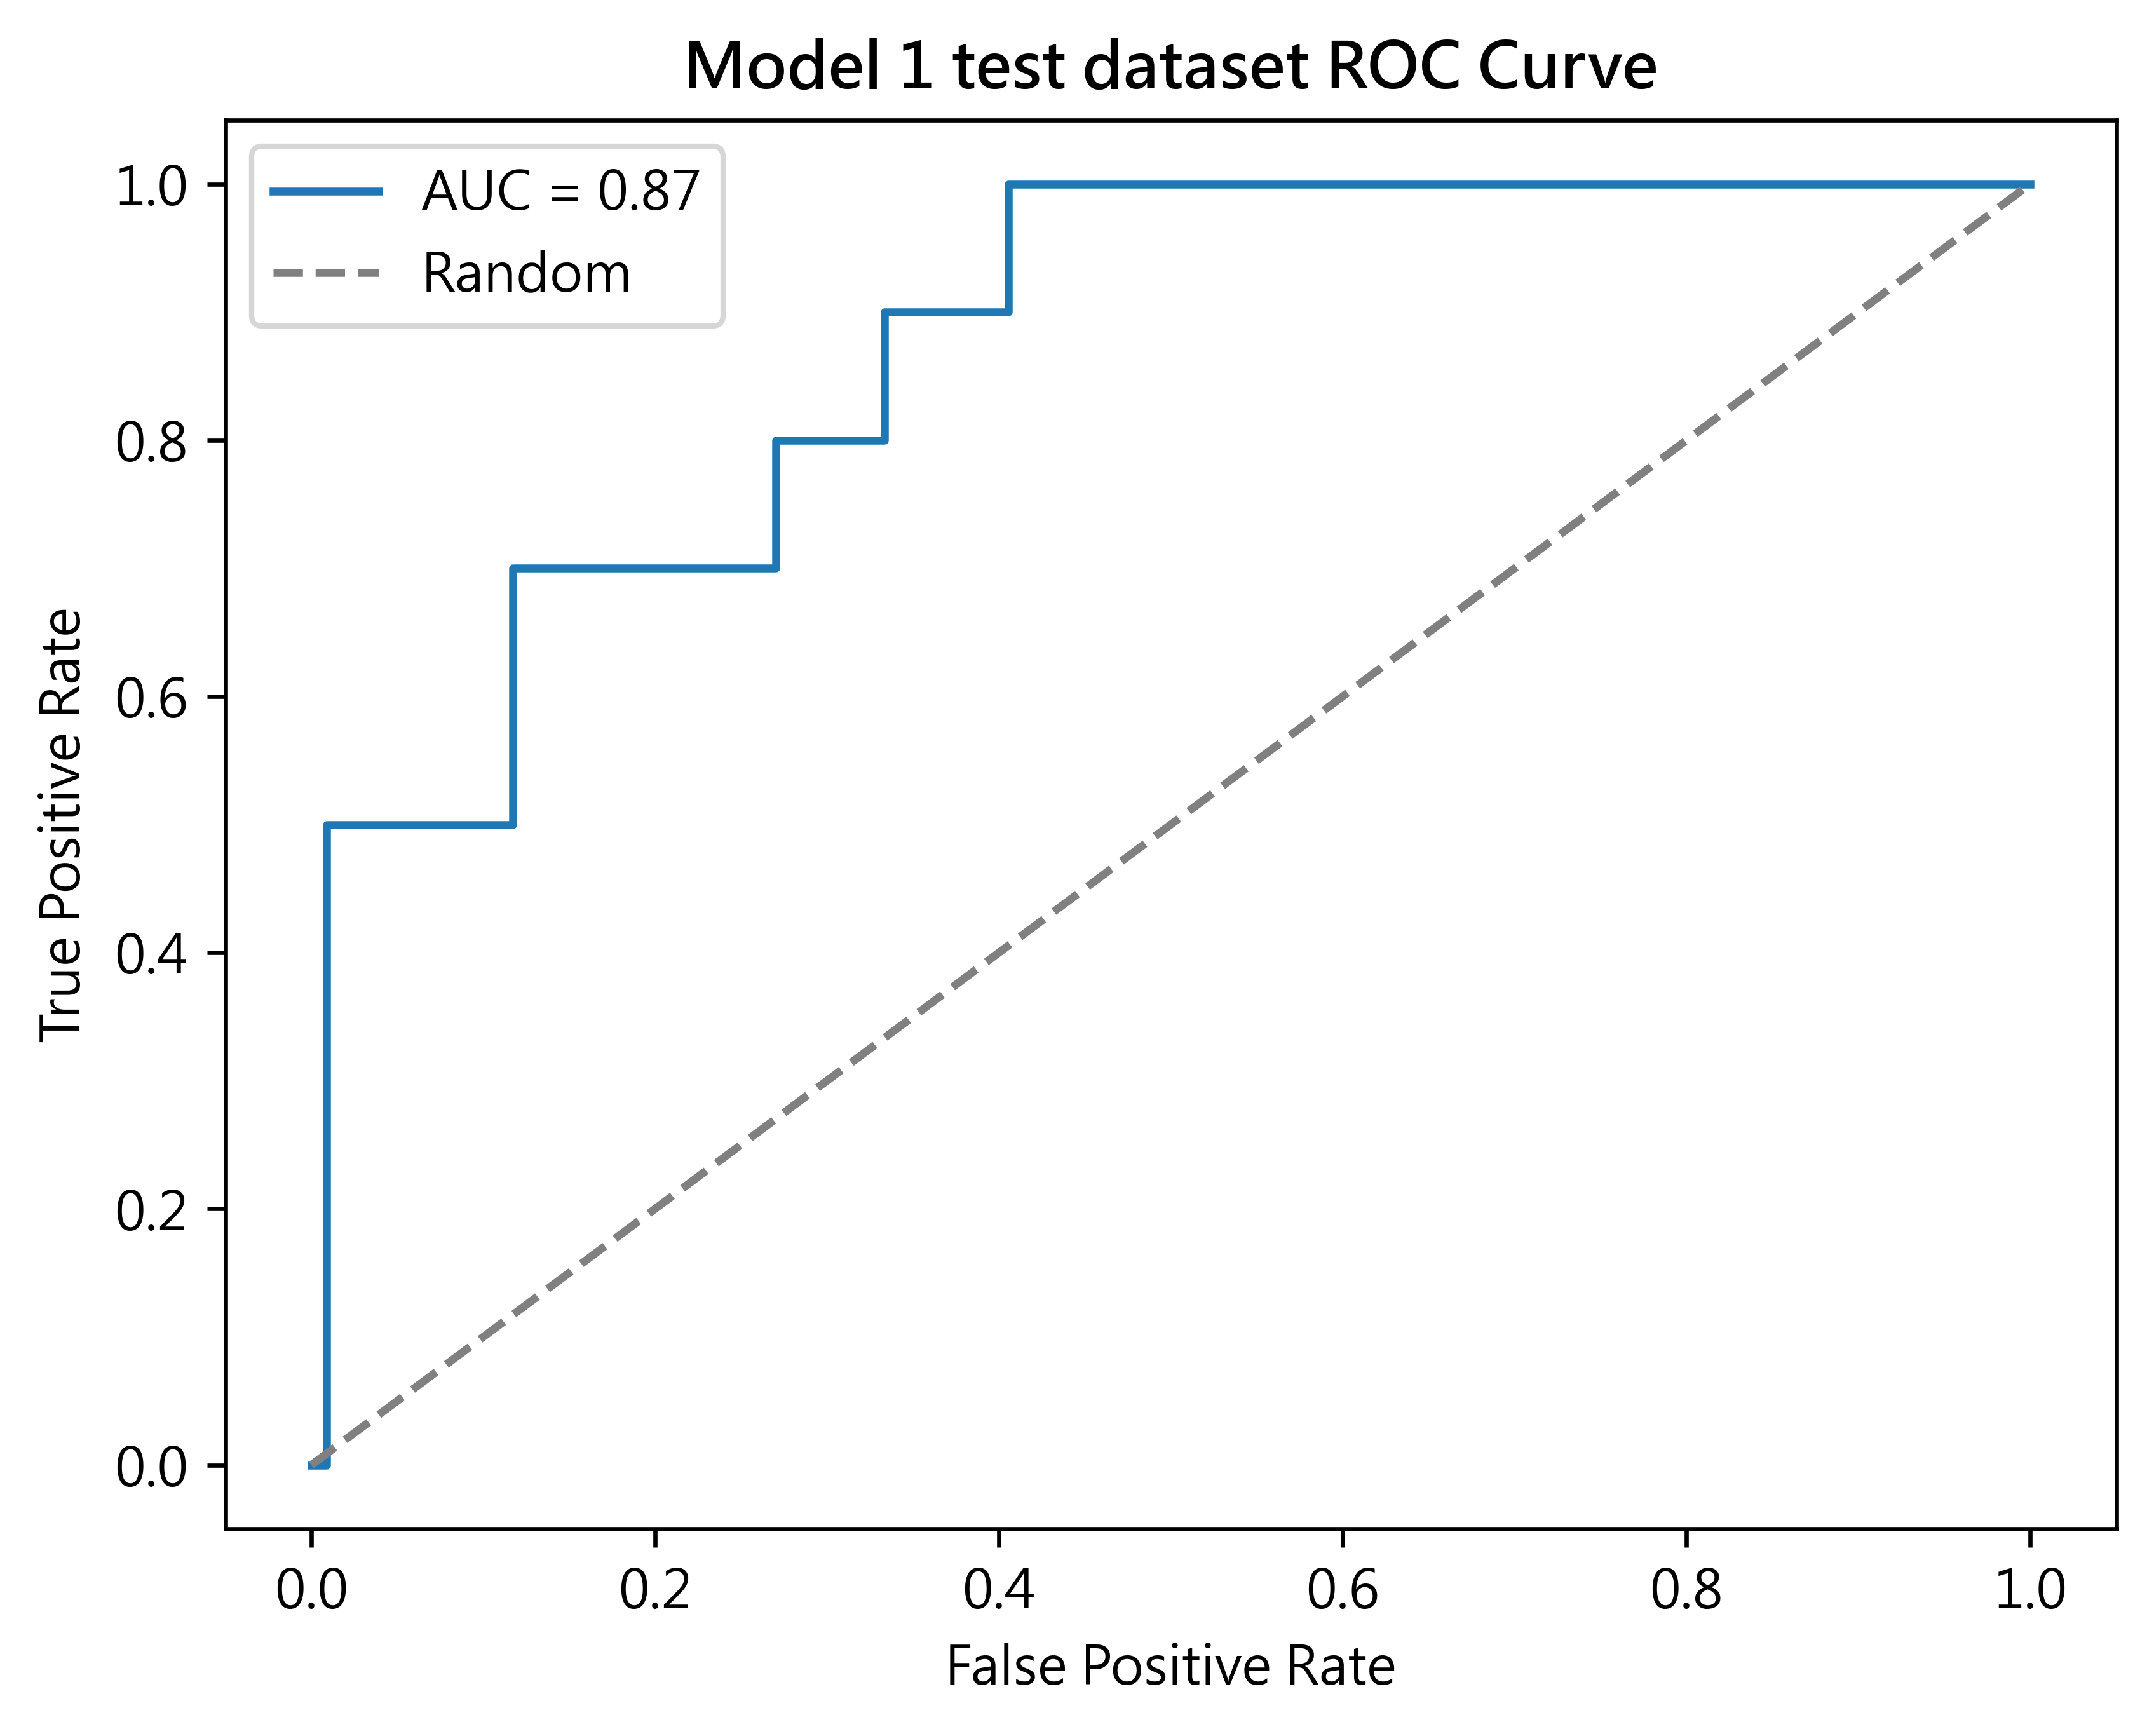


=== 閾值0.01-1.00的評估結果 ===

Cut-off: 0.00
Confusion Matrix:
[[  0 440]
 [  0  42]]
Type I Error : 0.0000
Type II Error : 1.0000
Accuracy : 0.0871
Precision : 0.0871
Recall : 1.0000
Total Errors : 440
--------------------------------------------------

Cut-off: 0.01
Confusion Matrix:
[[230 210]
 [  0  42]]
Type I Error : 0.0000
Type II Error : 0.4773
Accuracy : 0.5643
Precision : 0.1667
Recall : 1.0000
Total Errors : 210
--------------------------------------------------

Cut-off: 0.02
Confusion Matrix:
[[294 146]
 [  2  40]]
Type I Error : 0.0476
Type II Error : 0.3318
Accuracy : 0.6929
Precision : 0.2151
Recall : 0.9524
Total Errors : 148
--------------------------------------------------

Cut-off: 0.03
Confusion Matrix:
[[322 118]
 [  2  40]]
Type I Error : 0.0476
Type II Error : 0.2682
Accuracy : 0.7510
Precision : 0.2532
Recall : 0.9524
Total Errors : 120
--------------------------------------------------

Cut-off: 0.04
Confusion Matrix:
[[340 100]
 [  3  39]]
Type I Error : 0.0714


In [17]:
# pip install python-docx
from docx import Document
from docx.shared import Inches
# Run the Logit model
def prepare_model_data(X_train_final, X_test_final, y_train):
    """準備模型數據和訓練模型"""
    X_train_final = sm.add_constant(X_train_final)
    X_test_final = sm.add_constant(X_test_final)
    model = sm.Logit(y_train, X_train_final)
    result = model.fit()
    return X_train_final, X_test_final, result

def evaluate_predictions(y_true, y_pred):
    """計算混淆矩陣各種評估指標。"""
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    total = TP + TN + FP + FN
    accuracy = (TP + TN) / total
    type_1_error = FN / (FN + TP) if (FN + TP) > 0 else 0
    type_2_error = FP / (FP + TN) if (FP + TN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'type_1_error': type_1_error, 
        'type_2_error': type_2_error,
        'precision': precision,
        'recall': recall,
        'total_errors': FP + FN
    }

def Build_Logistic_Model(i, X_train_final, X_test_final, y_train, y_test):
    # 準備數據和訓練模型
    X_train_final, X_test_final, result = prepare_model_data(X_train_final, X_test_final, y_train)
    
    # 修改日期格式並印出結果
    summary = result.summary()
    summary.tables[0].data[3][1] = 'Tuesday, December 10 2024'
    print(summary)

    # 將結果存成Word檔
    doc = Document()
    doc.add_heading(f'Logistic Regression Model {i} Summary', level=1)
    doc.add_paragraph(str(summary))
    # 添加表格
    # table = doc.add_table(rows=1, cols=len(summary.columns))
    # hdr_cells = table.rows[0].cells
    # for j, col_name in enumerate(summary.columns):
    #     hdr_cells[j].text = col_name

    # for index, row in summary.iterrows():
    #     row_cells = table.add_row().cells
    #     for j, value in enumerate(row):
    #         row_cells[j].text = str(value)
    
    doc.save(f'Logistic_Model_{i}_Summary.docx')
    
    # 計算預測機率
    y_train_prob = result.predict(X_train_final)
    y_test_prob = result.predict(X_test_final[:len(y_test)])

    # 繪製ROC曲線的函數
    def plot_roc_curve(y_true, y_prob, dataset_type):
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        
        plt.figure(dpi=600)
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Model {i} {dataset_type} ROC Curve', fontweight='bold')
        plt.legend()
        plt.show()

    # 繪製ROC曲線
    plot_roc_curve(y_train, y_train_prob, "training dataset")
    plot_roc_curve(y_test, y_test_prob, "test dataset")

    # 只評估訓練集的不同閾值
    def evaluate_thresholds(thresholds, y_train, y_train_prob, label):
        """評估不同閾值的模型表現，並找出最佳閾值。"""
        print(f"\n=== {label} ===")
        best_threshold = 0
        best_accuracy = 0
        best_type_1_error = float('inf')
        results_list = []
        
        for threshold in thresholds:
            y_train_pred = (y_train_prob >= threshold).astype(int)
            results = evaluate_predictions(y_train, y_train_pred)
            
            results_list.append({
                'threshold': threshold,
                'results': results
            })
            
            # 記錄最佳閾值（基於準確率）
            if results['accuracy'] >=0.90 and results['type_1_error'] < best_type_1_error:
                best_type_1_error = results['type_1_error']
                best_accuracy = results['accuracy']
                best_threshold = threshold
            
            print(f'\nCut-off: {threshold:.2f}')
            print('Confusion Matrix:')
            print(results['confusion_matrix'])
            print(f'Type I Error : {results["type_1_error"]:.4f}')
            print(f'Type II Error : {results["type_2_error"]:.4f}')
            print(f'Accuracy : {results["accuracy"]:.4f}')
            print(f'Precision : {results["precision"]:.4f}')
            print(f'Recall : {results["recall"]:.4f}')
            print(f'Total Errors : {results["total_errors"]}')
            print('-' * 50)
            
        print(f"\n最佳閾值: {best_threshold:.2f} (準確率: {best_accuracy:.4f})")
        return best_threshold, results_list

    # 評估不同範圍的閾值

    evaluate_best_threshold = evaluate_thresholds([i/100 for i in range(101)], y_train, y_train_prob, "閾值0.01-1.00的評估結果")
    best_threshold = evaluate_best_threshold[0]

    return evaluate_best_threshold, best_threshold  # 返回找到的最佳閾值

def Draw_Confusion_Matrix(i, cut_off,X_train_final, X_test_final, y_train, y_test):

    # 添加截距項
    X_train_final = sm.add_constant(X_train_final)
    X_test_final = sm.add_constant(X_test_final)

    # 建立模型
    model = sm.Logit(y_train, X_train_final)
    result = model.fit()

    # 訓練集預測
    y_train_prob = result.predict(X_train_final)
    y_train_pred = (y_train_prob >= float(cut_off)).astype(int)
    
    # 測試集預測
    y_test_prob = result.predict(X_test_final[:len(y_test)])
    y_test_pred = (y_test_prob >= float(cut_off)).astype(int)

    # 創建混淆矩陣
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)    

    # 重新排列混淆矩陣
    # cm = np.flip(cm)  # 上下翻轉
    cm_train = np.flip(cm_train)
    cm_test = np.flip(cm_test)


    # 計算訓練集評估指標
    TN_train, FP_train, FN_train, TP_train = confusion_matrix(y_train, y_train_pred).ravel()
    accuracy_train = (TP_train + TN_train) / (TP_train + TN_train + FP_train + FN_train)
    type_1_error_train = FN_train / (FN_train + TP_train) if (FN_train + TP_train) > 0 else 0
    type_2_error_train = FP_train / (FP_train + TN_train) if (FP_train + TN_train) > 0 else 0

    # 計算測試集評估指標
    TN_test, FP_test, FN_test, TP_test = confusion_matrix(y_test, y_test_pred).ravel()
    accuracy_test = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test)
    type_1_error_test = FN_test / (FN_test + TP_test) if (FN_test + TP_test) > 0 else 0
    type_2_error_test = FP_test / (FP_test + TN_test) if (FP_test + TN_test) > 0 else 0

    # 繪製訓練集與測試集的混淆矩陣
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=600)

    # 訓練集混淆矩陣
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Default', 'Non-Default'],
                yticklabels=['Default', 'Non-Default'],
                annot_kws={'size': 18},
                ax=ax1)
    # 將x軸標籤移到頂部
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    
    ax1.set_title(f'Model {i} training datatest Confusion Matrix\n'
                 f'Accuracy: {accuracy_train:.4f}\n'
                 f'Type I Error: {type_1_error_train:.4f}\n'
                 f'Type II Error: {type_2_error_train:.4f}',
                 fontweight='bold', pad=50)
    
    ax1.set_xlabel('Predicted Value')
    ax1.set_ylabel('Actual Value')
   # 測試集混淆矩陣
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
               xticklabels=['Default', 'Non-Default'],
               yticklabels=['Default', 'Non-Default'],
               annot_kws={'size': 18},
               ax=ax2)
    ax2.xaxis.set_ticks_position('top')
    ax2.xaxis.set_label_position('top')
    ax2.set_title(f'Model {i} test datatest Confusion Matrix\n'
                 f'Accuracy: {accuracy_test:.4f}\n'
                 f'Type I Error: {type_1_error_test:.4f}\n'
                 f'Type II Error: {type_2_error_test:.4f}',
                 fontweight='bold', pad=50)
    ax2.set_xlabel('Predicted Value')
    ax2.set_ylabel('Actual Value')

    plt.tight_layout()
    plt.show()

# 使用方式
# Build_Logistic_Model(1, X_train_final_1, X_test_final_1, y_train, y_test)
threshold_result, best_threshold = Build_Logistic_Model(1, X_train_final_1, X_test_final_1, y_train, y_test)
Draw_Confusion_Matrix(1, best_threshold, X_train_final_1, X_test_final_1, y_train, y_test)
